# Global Internet Usage: Analysis Notebook
This notebook is dedicated to the exploration and analysis of Gapminder's [Global Internet Usage dataset](https://www.kaggle.com/datasets/sansuthi/gapminder-internet).

### Initial assessment

In [1]:
# The usual formalities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
%matplotlib inline

df = pd.read_csv('./gapminder_internet.csv')
df.head()

,country,incomeperperson,internetuserate,urbanrate
0,Afghanistan,NaN,3.654122,24.04
1,Albania,1914.996551,44.989947,46.72
2,Algeria,2231.993335,12.500073,65.22
3,Andorra,21943.339900,81.000000,88.92
4,Angola,1381.004268,9.999954,56.70


I'm going to go over each column as it's described on Kaggle:
* **Country**: The name of the country.
* **Income per person**: The country's Gross Domestic Product per capita.
* **Internet use rate**: The percentage of the country's population, as a number from 0 to 100, that uses the Internet.
* **Urban rate**: The percentage of the country's population, as a number from 0 to 100, that lives in an urban area.

In [2]:
# Make some exploratory queries
df.describe()

,incomeperperson,internetuserate,urbanrate
count,190.000000,192.000000,203.000000
mean,8740.966076,35.632716,56.769360
std,14262.809083,27.780285,23.844933
min,103.775857,0.210066,10.400000
25%,748.245151,9.999604,36.830000
50%,2553.496056,31.810121,57.940000
75%,9379.891166,56.416046,74.210000
max,105147.437700,95.638113,100.000000


In [3]:
df.shape

(213, 4)

In [4]:
df.isna().sum()

country             0
incomeperperson    23
internetuserate    21
urbanrate          10
dtype: int64

For easy reference, a list of the questions I set out to answer, from lowest difficulty to highest:
* Where does my country, the United States, fall in the statistics?
* The infographic claims that 66.2% of people worldwide use the Internet.  Can this be verified?
* Is urban population significantly correlated with Internet usage?  Is income per person?
* Can Internet use rate be accurately predicted from income per person and/or urban population?

## Question 1: Where does my country, the United States, fall in the statistics?

### Analysis

In [5]:
# What are the statistics for the United States?
df[df['country'] == 'United States']

,country,incomeperperson,internetuserate,urbanrate
203,United States,37491.17952,74.247572,81.7


In [6]:
#Create a sorted version of the dataset
df_sorted = df.sort_values('internetuserate', ascending=False, ignore_index=True)
df_sorted.head()

,country,incomeperperson,internetuserate,urbanrate
0,Iceland,33945.31442,95.638113,92.26
1,Norway,39972.35277,93.277508,77.48
2,Netherlands,26551.84424,90.703555,81.82
3,Luxembourg,52301.58718,90.079527,82.44
4,Sweden,32292.48298,90.016190,84.54


In [7]:
# See where the United States stands in this new dataset
df_sorted[df_sorted['country'] == 'United States']

,country,incomeperperson,internetuserate,urbanrate
25,United States,37491.17952,74.247572,81.7


In [8]:
# See the window
i = df_sorted[df_sorted['country'] == 'United States'].index[0]
df_sorted[i-2:i+3]

,country,incomeperperson,internetuserate,urbanrate
23,Australia,25249.986060,75.895654,88.74
24,Faeroe Islands,NaN,75.200000,41.42
25,United States,37491.179520,74.247572,81.70
26,Estonia,6238.537506,74.163040,69.46
27,Belgium,24496.048260,73.733934,97.36


In [9]:
# This seems useful, I'll make a function out of it
def window(df, n, criterion):
    '''
    INPUT:
    df - Pandas dataframe, preferably sorted by the most relevant column
    n - The desired number of rows to return before and after the point of interest.  An n of 2 will return 5 rows total.
    criterion - A Boolean condition that returns true only for the point of interest.
    
    OUTPUT:
    df_subset - A subset of df that contains 2n+1 rows, centered around the row identified by criterion.
    
    Return a subset of df that highlights the row identified by criterion, and its n nearest neighbors in each direction.
    This function can be used to see subsets of the data easily, like the head and tail functions, centered around a point of interest.
    '''
    
    i = df[criterion].index[0]
    head = max(i-n, 0) #Account for the lower bound
    tail = min(i+n+1, df.shape[0]) #Account for the upper bound
    df_subset = df[head:tail] #Remember, start is inclusive, but stop isn't!
    return df_subset;

# This should output the same as the last code cell
window(df_sorted, 2, df_sorted['country'] == 'United States')

,country,incomeperperson,internetuserate,urbanrate
23,Australia,25249.986060,75.895654,88.74
24,Faeroe Islands,NaN,75.200000,41.42
25,United States,37491.179520,74.247572,81.70
26,Estonia,6238.537506,74.163040,69.46
27,Belgium,24496.048260,73.733934,97.36


In [10]:
# Widen the window now
window(df_sorted, 5, df_sorted['country'] == 'United States')

,country,incomeperperson,internetuserate,urbanrate
20,Japan,39309.478860,77.638535,66.48
21,France,22878.466570,77.498619,77.36
22,Saint Kitts and Nevis,9175.796015,76.587538,32.32
23,Australia,25249.986060,75.895654,88.74
24,Faeroe Islands,NaN,75.200000,41.42
25,United States,37491.179520,74.247572,81.70
26,Estonia,6238.537506,74.163040,69.46
27,Belgium,24496.048260,73.733934,97.36
28,Austria,26692.984110,72.731576,67.16
29,"Hong Kong, China",35536.072470,71.849124,100.00


In [11]:
# Try it yourself!  Change the variables below and run the code cell
country_name = 'United States'
window_size = 5
window(df_sorted, window_size, df_sorted['country'] == country_name)

,country,incomeperperson,internetuserate,urbanrate
20,Japan,39309.478860,77.638535,66.48
21,France,22878.466570,77.498619,77.36
22,Saint Kitts and Nevis,9175.796015,76.587538,32.32
23,Australia,25249.986060,75.895654,88.74
24,Faeroe Islands,NaN,75.200000,41.42
25,United States,37491.179520,74.247572,81.70
26,Estonia,6238.537506,74.163040,69.46
27,Belgium,24496.048260,73.733934,97.36
28,Austria,26692.984110,72.731576,67.16
29,"Hong Kong, China",35536.072470,71.849124,100.00


### Conclusion
It looks as though the United States is the 26th most Internet-using country in the world, sitting neatly in the top quartile.  It is outdone by the likes of Japan, France, and Australia, but outperforms Hong Kong and China, as well as Belgium and Austria.

## Question 2: The infographic claims that 66.2% of people worldwide use the Internet.  Can this be verified?

### Analysis and re-assessment

In [12]:
# Next question: What's the mean of Internet usage throughout the world?
df['internetuserate'].mean()

35.632715769020834

35.6%.  This seems to contradict the 66.2% number on the infographic, but I should point out that **this is not a fair average**.  Some countries have greater populations than others, and as a result their numbers are weighted more.  Unfortunately, it is impossible to adjust for this, since the dataset does not contain anything in the way of raw population numbers, nor the date on which the information was gathered; GapMinder must have cheated by involving data not reported in the dataset.

### Conclusion

**This question cannot be answered due to missing information.**  Thus, I am forced to abandon this line of questioning and move on.

## Question 3: Is urban population significantly correlated with Internet usage?  Is income per person?

### Visualization

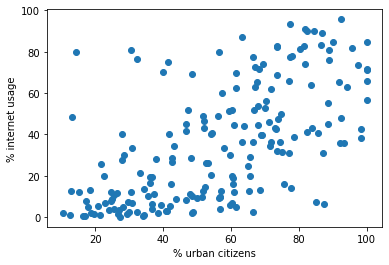

In [13]:
# Question three: Does urban population correlate with Internet usage?  Let's plot a graph
plt.xlabel('% urban citizens')
plt.ylabel('% internet usage')
plt.scatter(df['urbanrate'], df['internetuserate'])

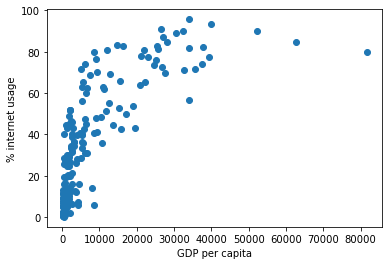

In [14]:
# Now do the same with income per person.
plt.xlabel('GDP per capita')
plt.ylabel('% internet usage')
plt.scatter(df['incomeperperson'], df['internetuserate'])

Both graphs show vague positive correlations, but with lots of noise.  The correlation is linear in the case of urban population, but more quadratic in the case of income per person.

### Conclusion

**Both urban citizenship and GDP per capita correlate positively, albeit weakly, with Internet usage.**  This shows promise for the final line of inquiry...

## Question 4: Can Internet use rate be accurately predicted from income per person and/or urban population?

### Cleaning

In [15]:
#Create a more usable subset of the dataset
df_ml = df.drop('country', axis=1).dropna()
df_ml.shape

(182, 3)

In [16]:
df_ml.head()

,incomeperperson,internetuserate,urbanrate
1,1914.996551,44.989947,46.72
2,2231.993335,12.500073,65.22
3,21943.339900,81.000000,88.92
4,1381.004268,9.999954,56.70
5,11894.464070,80.645455,30.46


I've dropped the **country** column because country names are intuitively useless for solving this problem.

I've also removed the rows with NA's because as small as this dataset is, replacing the NA's with dummy variables of any sort would most likely skew the results noticeably.

There are no categorical variables in this dataset (unless you count the country names we already dropped), so there is no need to handle them.

### Modeling

Now for the fun part: setting up the model.

In [17]:
#Split the data for training and testing
X = df_ml[['incomeperperson', 'urbanrate']]
y = df_ml['internetuserate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=413)

#Instantiate
model = LinearRegression(normalize=True) 

#Fit
model.fit(X_train, y_train)

#Predict
preds = model.predict(X_test)

#Score
score = r2_score(y_test, preds)
print(score)

0.7338985178573594


Considering that 1 is a perfect score and 0 is as good as random, a score of 0.734 is pretty good.

### Conclusion

**Yes, Internet usage can be predicted from urban citizenship and GDP per capita.**  Not perfectly, of course, but reasonably well.